# From Numbers to Insights: A Deep Dive into Retail

This project analyzes sales data from a UK-based online retail store, specializing in unique gifts. Using publicly available data, I aim to uncover key insights from more than a year’s worth of transactions, focusing on trends and customer behaviors. My objective is to respond to the following question: **WHAT HAPPENED?**

In [3]:
import pandas as pd
# from ucimlrepo import fetch_ucirepo 

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

## 1) Data collection

In this project I used transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. Data was obtained from the *UCI Machine Learning public* repository:

In [6]:
file_path = "data/Sales_Data.xlsx"  
data = pd.read_excel(file_path, header=None)

# As we can see, the issue was when detecting the headers, so we consider them as values
print(data.head())

# Manually set the headers
data.columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

# Remove the first row, as it duplicates the headers
data = data.drop(index=0)
data = data.reset_index(drop=True)

# Check column names and data
print(data.columns)


           0          1                                    2         3  \
0  InvoiceNo  StockCode                          Description  Quantity   
1     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
2     536365      71053                  WHITE METAL LANTERN         6   
3     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
4     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   

                     4          5           6               7  
0          InvoiceDate  UnitPrice  CustomerID         Country  
1  2010-12-01 08:26:00       2.55       17850  United Kingdom  
2  2010-12-01 08:26:00       3.39       17850  United Kingdom  
3  2010-12-01 08:26:00       2.75       17850  United Kingdom  
4  2010-12-01 08:26:00       3.39       17850  United Kingdom  
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


## 2) Data understanding and pre-processing

Each column needs a **correct data type** according to their values:

In [9]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [10]:
data.dtypes

InvoiceNo      object
StockCode      object
Description    object
Quantity       object
InvoiceDate    object
UnitPrice      object
CustomerID     object
Country        object
dtype: object

In [11]:
# Convert InvoiceNo to num (first float, then after dealing with nulls to integer)
data['InvoiceNo'] = pd.to_numeric(data['InvoiceNo'], errors='coerce')

# Convert Quantity to num (first float, then after dealing with nulls to integer)
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')

# Convert UnitPrice to num
data['UnitPrice'] = pd.to_numeric(data['UnitPrice'], errors='coerce')

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')

# Convert CustomerID to num (first float, then after dealing with nulls to integer)
data['CustomerID'] = pd.to_numeric(data['CustomerID'], errors='coerce')

data.dtypes

InvoiceNo             float64
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Let's explore **basic data statistics** to understand their distribution (i.e. sales records, maximum values, most frequent country...):

In [13]:
# Basic statistics for numerical columns
print("Basic statistics for numerical columns:")
print(data.describe())

# Statistics for categorical columns
print("\nValue counts for categorical columns:")
print(data['Country'].value_counts().head(5)) # Top 5 countries
print("")
print(data['StockCode'].value_counts().head(10))  # Top 10 most selled stock items


Basic statistics for numerical columns:
           InvoiceNo       Quantity                    InvoiceDate  \
count  532618.000000  541909.000000                         541909   
mean   559965.752027       9.552250  2011-07-04 13:34:57.156386048   
min    536365.000000  -80995.000000            2010-12-01 08:26:00   
25%    547906.000000       1.000000            2011-03-28 11:34:00   
50%    560688.000000       3.000000            2011-07-19 17:17:00   
75%    571841.000000      10.000000            2011-10-19 11:27:00   
max    581587.000000   80995.000000            2011-12-09 12:50:00   
std     13428.417281     218.081158                            NaN   

           UnitPrice     CustomerID  
count  541909.000000  406829.000000  
mean        4.611114   15287.690570  
min    -11062.060000   12346.000000  
25%         1.250000   13953.000000  
50%         2.080000   15152.000000  
75%         4.130000   16791.000000  
max     38970.000000   18287.000000  
std        96.759853    1

Data is not always complete, so we need to check for **missing values** and deal with them:


In [15]:
# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
InvoiceNo        9291
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In our case, we have missing values in the description, invoice number and the CustomerID columns. We may keep empty descriptions, as they do not affect quite much to the data quality, so we can fill them with "Unknown". However, we cannot keep data with no identified customer or invoice, so we will remove empty records:

In [17]:
# Drop rows with missing CustomerID
data = data.dropna(subset=['CustomerID', 'InvoiceNo'])

# Fill missing values for Description
data['Description'] = data['Description'].fillna('Unknown')

In [18]:
# Now we can transform them to integers
data['InvoiceNo'] = data['InvoiceNo'].astype(int)
data['Quantity'] = data['Quantity'].astype(int)
data['CustomerID'] = data['CustomerID'].astype(int)

What about **duplicates**?

In [20]:
# Check for duplicates
duplicates = data.duplicated()
print("\nNumber of duplicate rows:", duplicates.sum())


Number of duplicate rows: 5192


In [21]:
# Drop duplicate rows if necessary
data = data.drop_duplicates()

Let's think about **more specific things that can lead to data errors**:

- Do all countries exist? ---- Yes, they make sense, even though sometimes it is unspecified
- Are dates really between 01/12/2010 and 09/12/2011? ---- Yes, just taking a look at max and min values in the basic statistics we can confirm it
- The InvoiceNo, Quantity and UnitPrice cannot be negative, do we have negative values? ----- Yes, we check for quantity and InvoiceNo, so we can remove them
- What about free items? Do they make sense? --- We check their descriptions and frequence, and they may be associated with promotions gifts... and their impact is really small, but we will remove them in this occasion (for other types of analysis we would use them)
- Do we have outliers in terms of quantities and prices? Are they feasible? --- Yes, most of the highest unit prices are related to postage, so we will skip them to focus on product entries. For quantity, we skip the first two highest quantities, which may be errors (>70k units) compared to the following (<5k).

In [23]:
# List countries
data['Country'].unique()


array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Bahrain', 'Malta', 'RSA'], dtype=object)

In [24]:
# Check for negative quantity values
print(data[data['Quantity']<0])

data = data[data['Quantity']>0]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []


In [25]:
print(data[data['UnitPrice']<0])

data = data[data['UnitPrice']>=0]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []


In [26]:
# Check rows with UnitPrice equal to 0
zero_price_entries = data[data['UnitPrice'] == 0]

print("Entries with UnitPrice equal to 0:")
print(zero_price_entries.head())

# Count occurrences
print("\nNumber of entries with UnitPrice equal to 0:", zero_price_entries.shape[0])


Entries with UnitPrice equal to 0:
       InvoiceNo StockCode                   Description  Quantity  \
9302      537197     22841  ROUND CAKE TIN VINTAGE GREEN         1   
33576     539263     22580  ADVENT CALENDAR GINGHAM SACK         4   
40089     539722     22423      REGENCY CAKESTAND 3 TIER        10   
47068     540372     22090       PAPER BUNTING RETROSPOT        24   
47070     540372     22553        PLASTERS IN TIN SKULLS        24   

              InvoiceDate  UnitPrice  CustomerID         Country  
9302  2010-12-05 14:02:00        0.0       12647         Germany  
33576 2010-12-16 14:36:00        0.0       16560  United Kingdom  
40089 2010-12-21 13:45:00        0.0       14911            EIRE  
47068 2011-01-06 16:41:00        0.0       13081  United Kingdom  
47070 2011-01-06 16:41:00        0.0       13081  United Kingdom  

Number of entries with UnitPrice equal to 0: 40


In [27]:
zero_price_entries['Description']

9302             ROUND CAKE TIN VINTAGE GREEN
33576            ADVENT CALENDAR GINGHAM SACK
40089                REGENCY CAKESTAND 3 TIER
47068                 PAPER BUNTING RETROSPOT
47070                  PLASTERS IN TIN SKULLS
56674           ORGANISER WOOD ANTIQUE WHITE 
86789            FAIRY CAKES NOTEBOOK A6 SIZE
130188    CERAMIC BOWL WITH LOVE HEART DESIGN
139453     MINI CAKE STAND  HANGING STRAWBERY
145208            HEART GARLAND RUSTIC PADDED
157042     CHILDS BREAKFAST SET CIRCUS PARADE
187613                          PARTY BUNTING
198383              SET OF 6 SOLDIER SKITTLES
279324             OVAL WALL MIRROR DIAMANTE 
282912               JAM MAKING SET WITH JARS
285657                                 Manual
298054             SET OF 6 NATIVITY MAGNETS 
314745       SET OF 2 CERAMIC PAINTED HEARTS 
314746    SET OF 2 CERAMIC CHRISTMAS REINDEER
314747               36 FOIL STAR CAKE CASES 
314748                     POLKADOT RAIN HAT 
358655             PADS TO MATCH A

In [28]:
# Calculate the percentage of zero prices
zero_price_percentage = (zero_price_entries.shape[0] / data.shape[0]) * 100
print(f"\nPercentage of zero UnitPrice values: {zero_price_percentage:.2f}%")



Percentage of zero UnitPrice values: 0.01%


In [29]:
# Remove rows where UnitPrice is zero
data = data[data['UnitPrice'] != 0]

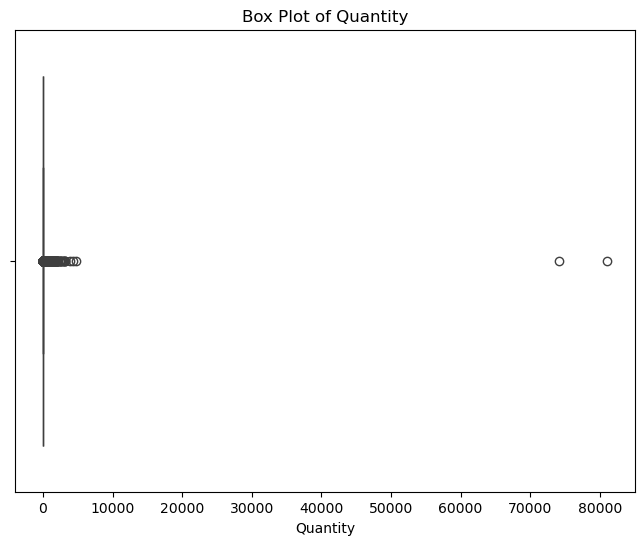

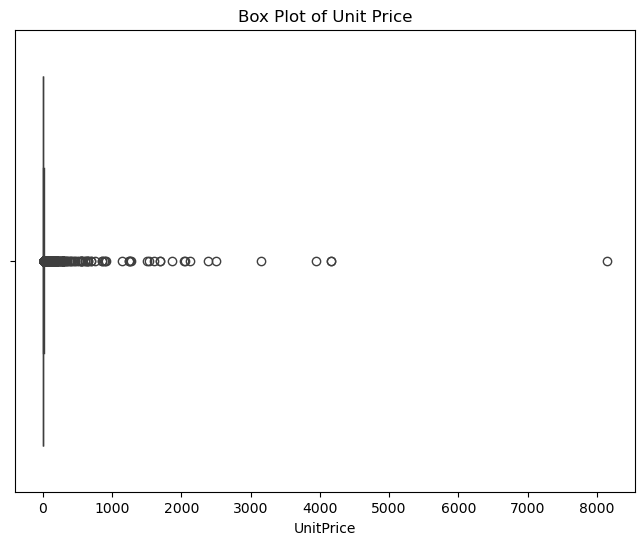


Number of outliers in Quantity: 25616

Number of outliers in Unit Price: 34112


In [30]:
# Outliers

# Box plot for Quantity
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Quantity'])
plt.title('Box Plot of Quantity')
plt.show()

# Box plot for UnitPrice
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['UnitPrice'])
plt.title('Box Plot of Unit Price')
plt.show()

# Calculate IQR for Quantity
Q1_quantity = data['Quantity'].quantile(0.25)
Q3_quantity = data['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity

# Define outlier boundaries
lower_bound_quantity = Q1_quantity - 1.5 * IQR_quantity
upper_bound_quantity = Q3_quantity + 1.5 * IQR_quantity

# Detect outliers
outliers_quantity = data[(data['Quantity'] < lower_bound_quantity) | (data['Quantity'] > upper_bound_quantity)]
print("\nNumber of outliers in Quantity:", outliers_quantity.shape[0])

# Calculate IQR for UnitPrice
Q1_price = data['UnitPrice'].quantile(0.25)
Q3_price = data['UnitPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Define outlier boundaries
lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

# Detect outliers
outliers_price = data[(data['UnitPrice'] < lower_bound_price) | (data['UnitPrice'] > upper_bound_price)]
print("\nNumber of outliers in Unit Price:", outliers_price.shape[0])



In [31]:
# Sort Quantity outliers by Quantity (descending) and then by UnitPrice (descending)
sorted_quantity_outliers = outliers_quantity.sort_values(by=['Quantity', 'UnitPrice'], ascending=[False, False])

# Display the top rows of the sorted Quantity outliers
print("Sorted Outliers by Quantity and UnitPrice:")
print(sorted_quantity_outliers[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'InvoiceDate', 'CustomerID', 'Country']].head())



Sorted Outliers by Quantity and UnitPrice:
        InvoiceNo StockCode                        Description  Quantity  \
540421     581483     23843        PAPER CRAFT , LITTLE BIRDIE     80995   
61619      541431     23166     MEDIUM CERAMIC TOP STORAGE JAR     74215   
421632     573008     84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS      4800   
206121     554868     22197               SMALL POPCORN HOLDER      4300   
97432      544612     22053              EMPIRE DESIGN ROSETTE      3906   

        UnitPrice         InvoiceDate  CustomerID         Country  
540421       2.08 2011-12-09 09:15:00       16446  United Kingdom  
61619        1.04 2011-01-18 10:01:00       12346  United Kingdom  
421632       0.21 2011-10-27 12:26:00       12901  United Kingdom  
206121       0.72 2011-05-27 10:52:00       13135  United Kingdom  
97432        0.82 2011-02-22 10:43:00       18087  United Kingdom  


In [32]:
data = data[data['Quantity'] <= 5000]

In [33]:
# Sort UnitPrice outliers by UnitPrice (descending) and then by Quantity (descending)
sorted_price_outliers = outliers_price.sort_values(by=['UnitPrice', 'Quantity'], ascending=[False, False])

# Display the top rows of the sorted UnitPrice outliers
print("Sorted Outliers by UnitPrice and Quantity:")
print(sorted_price_outliers[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'InvoiceDate', 'CustomerID', 'Country']].head(20))


Sorted Outliers by UnitPrice and Quantity:
        InvoiceNo StockCode     Description  Quantity  UnitPrice  \
173382     551697      POST         POSTAGE         1    8142.75   
422351     573077         M          Manual         1    4161.06   
422376     573080         M          Manual         1    4161.06   
406406     571751         M          Manual         1    3949.32   
374542     569382         M          Manual         1    3155.95   
297438     562946         M          Manual         1    2500.00   
144826     548813         M          Manual         1    2382.92   
406407     571751         M          Manual         1    2118.74   
144829     548820         M          Manual         1    2053.07   
343000     566927         M          Manual         1    2033.10   
150615     549468         M          Manual         1    1867.86   
117054     546328         M          Manual         1    1687.17   
117055     546329         M          Manual         1    1687.17   
52808

In [34]:
# List of descriptions to exclude
exclude_descriptions = ['POSTAGE', 'Manual', 'DOTCOM POSTAGE']

# Filter out rows with these descriptions
data = data[~data['Description'].isin(exclude_descriptions)]



In [35]:
# data.to_excel("data/Final_Sales_Data.xlsx", index=False)

## 3) Data visualization

### Aggregated Variables for Visualization

In our analysis, we can create several key aggregated metrics to gain deeper insights into the sales performance and customer behavior:

- **Total Sales**: Calculated as the product of `Quantity` and `UnitPrice`, representing the overall revenue generated by each transaction.

- **Total Revenue per Invoice**: Aggregated by summing the `TotalSales` for each invoice, providing insights into the total revenue associated with each transaction.

- **Number of Items per Invoice**: Determined by counting the number of items in each invoice, offering a perspective on the average basket size per customer.

- **Sales by Product, by Country, and by Customer**:
  - **By Product**: Summed `TotalSales` across all transactions to identify the top-selling products.
  - **By Country**: Summed `TotalSales` per country to compare regional sales performance.
  - **By Customer**: Aggregated `TotalSales` by each customer to understand customer-specific revenue contributions. <p></p>
  

- **Average Sales by Customer**: Computed as the ratio of `TotalSales` to the number of unique invoices for each customer, highlighting the average order value.

- **Sales Velocity**: Calculated as the quantity sold per day for each product, providing insight into how quickly products are moving in the inventory.


In [37]:
data['TotalSales'] = data['Quantity'] * data['UnitPrice']
# Filter for positive sales
data = data[data['TotalSales'] > 0]

# Aggregate total sales per invoice
revenue_per_invoice = data.groupby(['InvoiceNo', 'CustomerID'])[['InvoiceDate', 'TotalSales']].agg({
    'InvoiceDate': 'first',  # Keep the first InvoiceDate (or could be 'max', depending on the need)
    'TotalSales': 'sum'      # Sum TotalSales to get the total revenue per invoice
}).reset_index()
revenue_per_invoice.columns = ['InvoiceNo', 'CustomerID', 'InvoiceDate', 'TotalRevenue']

# Count the number of items per invoice
items_per_invoice = data[data['Quantity'] > 0].groupby('InvoiceNo').size().reset_index(name='NumberOfItems')

# Total sales by product
sales_by_product = data.groupby(['StockCode', 'Description'])['TotalSales'].sum().reset_index()
sales_by_product = sales_by_product.sort_values(by='TotalSales', ascending=False)

# Total sales by country
sales_by_country = data.groupby('Country')['TotalSales'].sum().reset_index()
uk_sales = sales_by_country[sales_by_country['Country'] == 'United Kingdom']['TotalSales'].sum()
intl_sales = sales_by_country[sales_by_country['Country'] != 'United Kingdom']['TotalSales'].sum()

# Total sales by customer
sales_by_customer = data.groupby('CustomerID')['TotalSales'].sum().reset_index()
sales_by_customer = sales_by_customer.sort_values(by='TotalSales', ascending=False)

avg_order_value_by_customer = data.groupby('CustomerID').agg({
    'TotalSales': 'sum',
    'InvoiceNo': 'nunique'
}).reset_index()
avg_order_value_by_customer['AvgOrderValue'] = avg_order_value_by_customer['TotalSales'] / avg_order_value_by_customer['InvoiceNo']
avg_order_value_by_customer = avg_order_value_by_customer.sort_values(by='TotalSales', ascending=False)

avg_sales_per_invoice_monthly = revenue_per_invoice.groupby(revenue_per_invoice['InvoiceDate'].dt.to_period('M'))['TotalRevenue'].mean().reset_index()
avg_sales_per_invoice_customer = revenue_per_invoice.groupby('CustomerID')['TotalRevenue'].mean().reset_index()

# Sales velocity: How quickly products are selling
sales_velocity = data.groupby('Description').agg({
    'TotalSales': 'sum',
    'Quantity': 'sum'
}).reset_index()
sales_velocity['Velocity'] = sales_velocity['Quantity'] / (data['InvoiceDate'].max() - data['InvoiceDate'].min()).days


In [38]:
# Let's check again just in case

duplicates = data[data.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)} \n")

missing_values = data.isnull().sum()
print(f"Number of missing values: \n{missing_values}")


Number of duplicate rows: 0 

Number of missing values: 
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalSales     0
dtype: int64


Now that we have all the data: Let's try to answer **WHAT HAPPENED?**

### Revenue Over Time

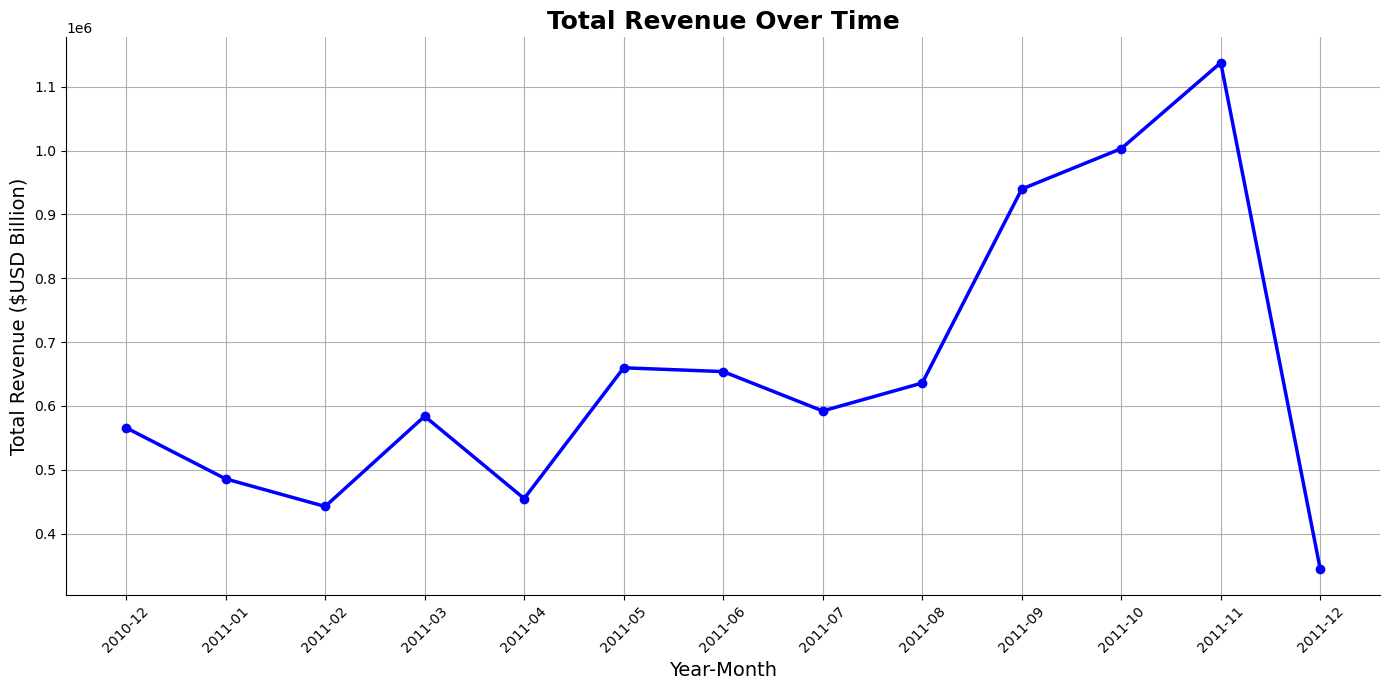

In [40]:
# Plotting Total Revenue Over Time in Millions of Dollars
plt.figure(figsize=(14, 7))
revenue_over_time = revenue_per_invoice.groupby(revenue_per_invoice['InvoiceDate'].dt.to_period('M'))['TotalRevenue'].sum()

plt.plot(revenue_over_time.index.astype(str), revenue_over_time, color='blue', marker='o', linewidth=2.5)

plt.title('Total Revenue Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Total Revenue ($USD Billion)', fontsize=14)
plt.grid(True)

# Customizing the appearance
sns.despine()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


The line plot of revenue over time show fluctuations in sales, with certain periods demonstrating spikes that could correspond to promotions, holidays, or other market events. This trend helps identify peak sales periods and potential seasonal effects. 

*Note that December data should not be interpreted as the dataset has only 9 days of activity on that month.

### Average Order Value by Customer

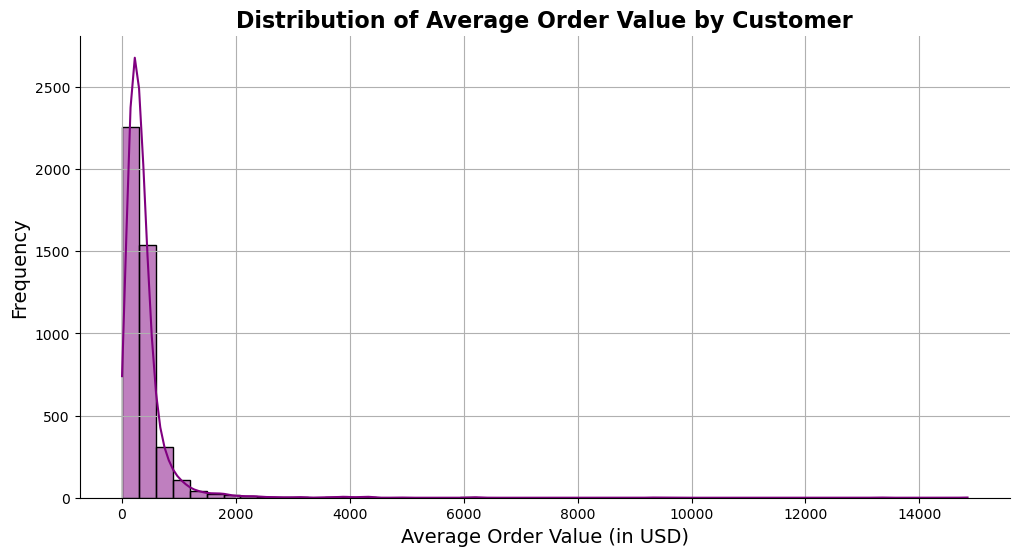

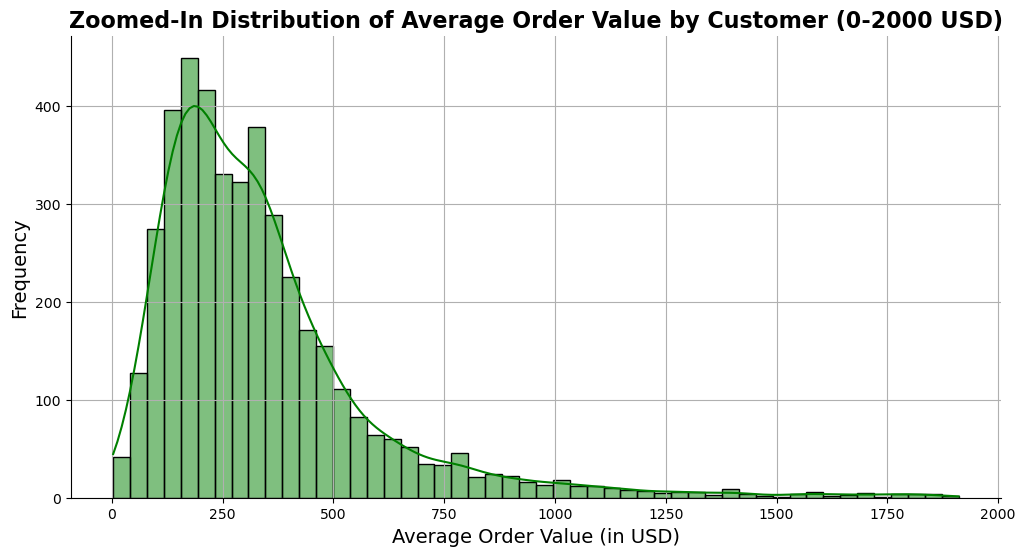

In [41]:
# Original Histogram of Average Order Value by Customer
plt.figure(figsize=(12, 6))
sns.histplot(avg_order_value_by_customer['AvgOrderValue'], bins=50, color='purple', kde=True)
plt.title('Distribution of Average Order Value by Customer', fontsize=16, fontweight='bold')
plt.xlabel('Average Order Value (in USD)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
sns.despine()
plt.show()

# Zoomed-in Histogram for $0-$2000 Range
plt.figure(figsize=(12, 6))
sns.histplot(avg_order_value_by_customer[avg_order_value_by_customer['AvgOrderValue'] <= 2000]['AvgOrderValue'], 
             bins=50, color='green', kde=True)
plt.title('Zoomed-In Distribution of Average Order Value by Customer (0-2000 USD)', fontsize=16, fontweight='bold')
plt.xlabel('Average Order Value (in USD)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
sns.despine()
plt.show()


The distribution of the first reveals that while a majority of customers made smaller purchases, a few high-value customers drove a significant portion of the revenue.  If we zoom in where most sales are, we see that most of the orders fall into the 100-500 USD$ range.

### Top 10 Selling Products

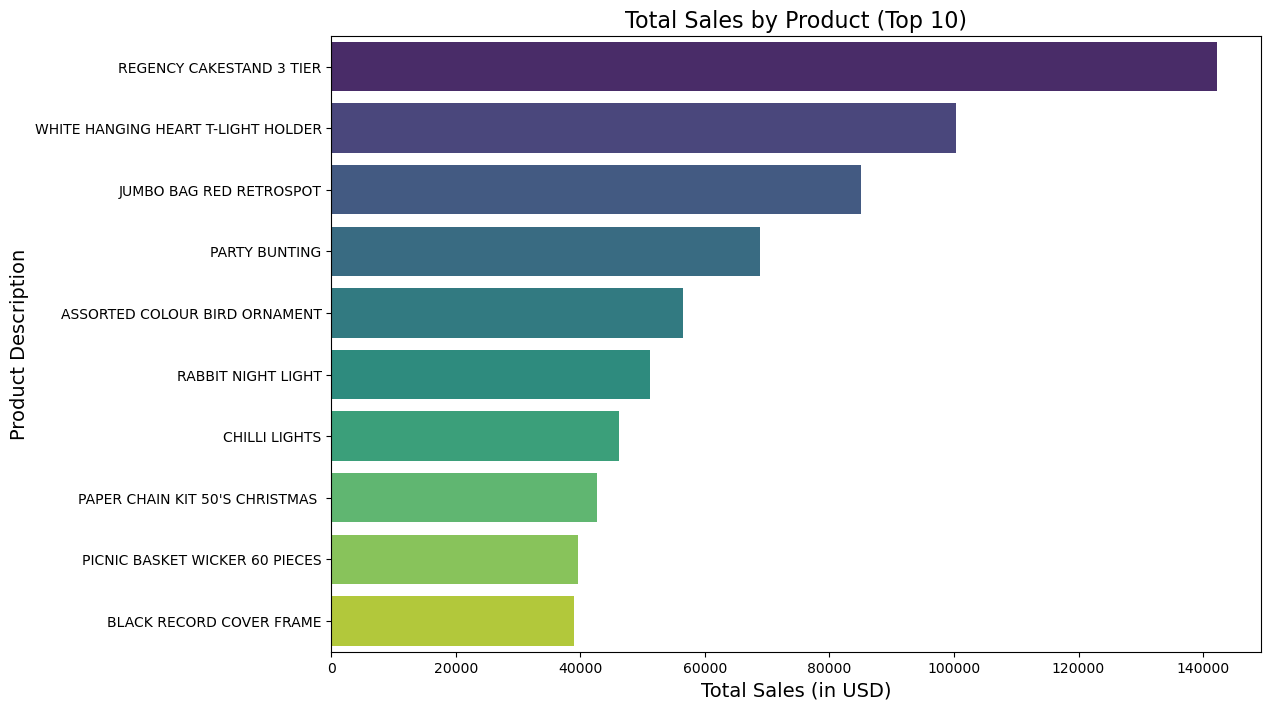

In [42]:
# Plotting Top 10 Selling Products
plt.figure(figsize=(12, 8))
top_products = sales_by_product.head(10)
sns.barplot(x='TotalSales', y='Description', hue='Description', data=top_products, palette='viridis')
plt.title('Total Sales by Product (Top 10)', fontsize=16)
plt.xlabel('Total Sales (in USD)', fontsize=14)
plt.ylabel('Product Description', fontsize=14)
plt.show()


This bar plot shows the most popular products in terms of how they contributed to the revenue.

### Country Sales

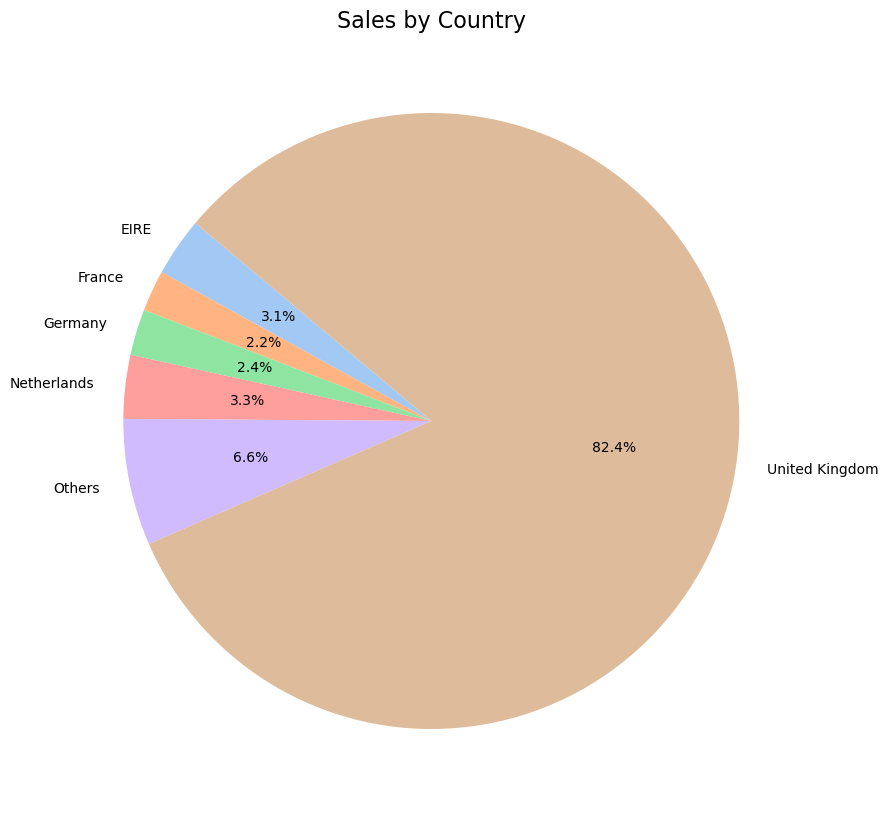

In [43]:
# Total Sales by Country
# Calculate the percentage of total sales for each country
sales_by_country['Percentage'] = (sales_by_country['TotalSales'] / sales_by_country['TotalSales'].sum()) * 100
# Group countries with less than 2% of total sales into an "Others" group
sales_by_country.loc[sales_by_country['Percentage'] < 2, 'Country'] = 'Others'

# Plotting Total Sales by Country
plt.figure(figsize=(10, 10))
sales_by_country = sales_by_country.groupby('Country', as_index=False)['TotalSales'].sum()
plt.pie(sales_by_country['TotalSales'], labels=sales_by_country['Country'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Sales by Country', fontsize=16)
plt.show()


The pie chart shows that the majority of sales are concentrated on the UK. This suggests a strong regional dependency in the business, with the need to either strengthen international sales or diversify market presence.

### Product Sales Velocity

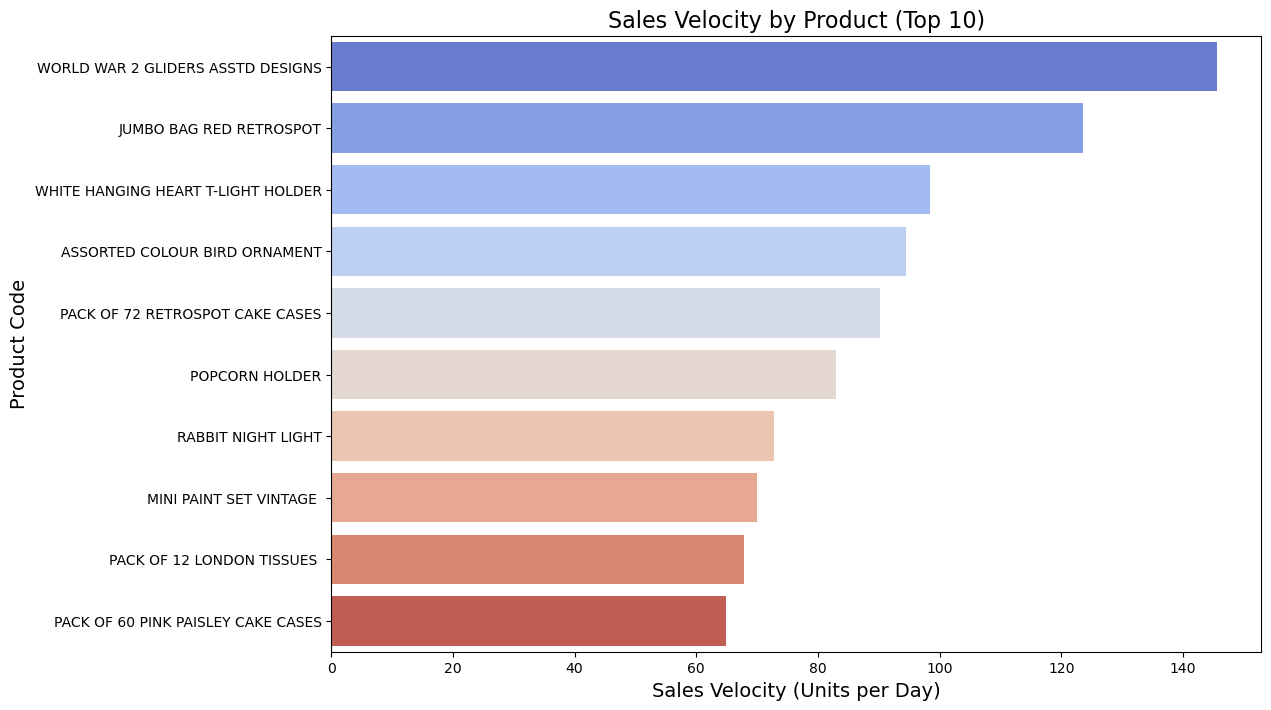

In [44]:
# Plotting Sales Velocity for Top Products
plt.figure(figsize=(12, 8))
top_velocity_products = sales_velocity.sort_values(by='Velocity', ascending=False).head(10)
sns.barplot(x='Velocity', hue='Description', y='Description', data=top_velocity_products, palette='coolwarm')
plt.title('Sales Velocity by Product (Top 10)', fontsize=16)
plt.xlabel('Sales Velocity (Units per Day)', fontsize=14)
plt.ylabel('Product Code', fontsize=14)
plt.show()


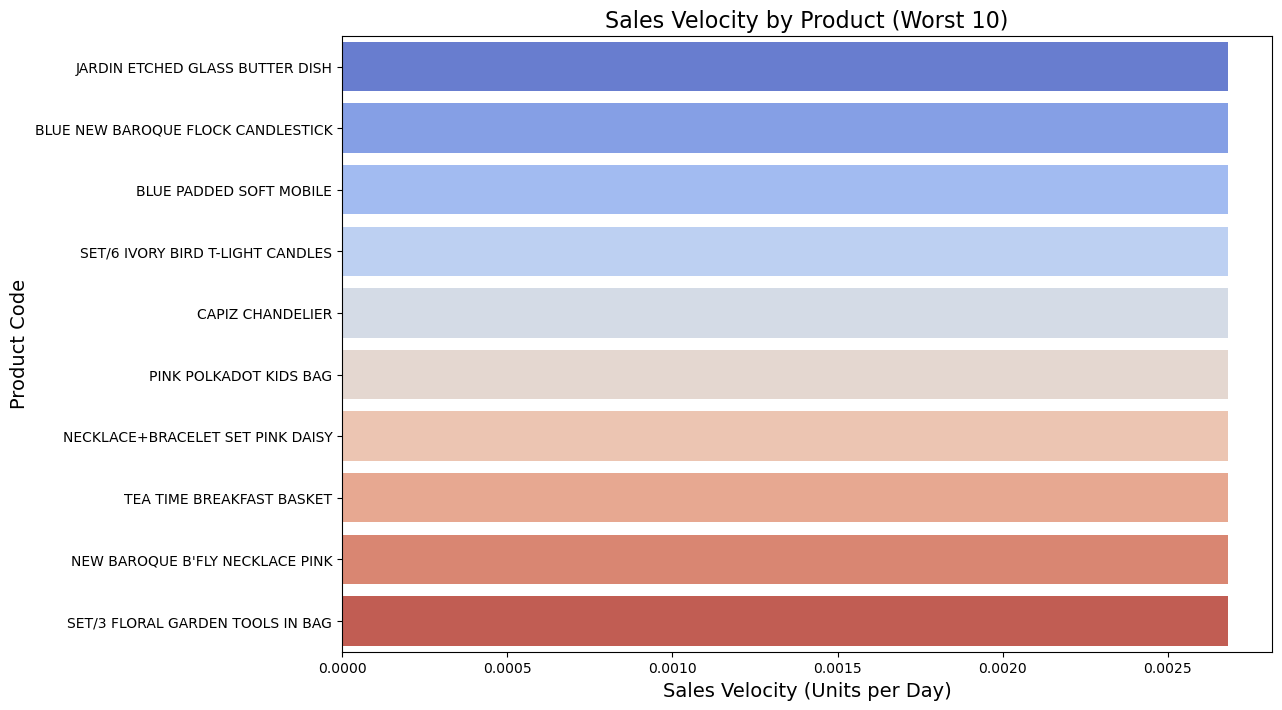

In [146]:
# Plotting Sales Velocity for Top Products
plt.figure(figsize=(12, 8))
top_velocity_products = sales_velocity.sort_values(by='Velocity', ascending=True).head(10)
sns.barplot(x='Velocity', hue='Description', y='Description', data=top_velocity_products, palette='coolwarm')
plt.title('Sales Velocity by Product (Worst 10)', fontsize=16)
plt.xlabel('Sales Velocity (Units per Day)', fontsize=14)
plt.ylabel('Product Code', fontsize=14)
plt.show()


This velocity plot demonstrated how quickly certain product have been sold (top best and worst).

----

## **Final Conclusions**

### **We can extract important conclusions from our analysis:**

- **Seasonality and Spikes**:  
  The revenue over time plot highlighted potential **seasonal effects** and **periods of heightened sales activity**, offering valuable insights for guiding marketing strategies and inventory planning.

- **Customer Segmentation**:  
  The average order value analysis underscored the significance of **segmenting customers** based on their purchasing behavior. Specifically, it emphasized the importance of **identifying and retaining high-value customers** to maximize revenue.

- **Product and Market Focus**:  
  The analysis of top-selling products and country sales distributions suggested that certain products and markets are **critical to the business's revenue**. This insight presents an opportunity to either capitalize further on these key areas or explore ways to **balance the revenue stream** across a broader range of products and regions. These findings can guide decisions related to inventory management, promotional efforts, and pricing strategies.

- **Operational Efficiency**:  
  Understanding **sales velocity** can significantly enhance inventory management. High-velocity products, which are in high demand, may require **frequent restocking**, while lower-velocity products might benefit from **promotional efforts** or a **re-evaluation of their place in inventory**.


## 4) Bonus

The design and aesthetics in this notebook are limited, so we can take a look a sample of a dashboard sheet done on the Power BI tool:

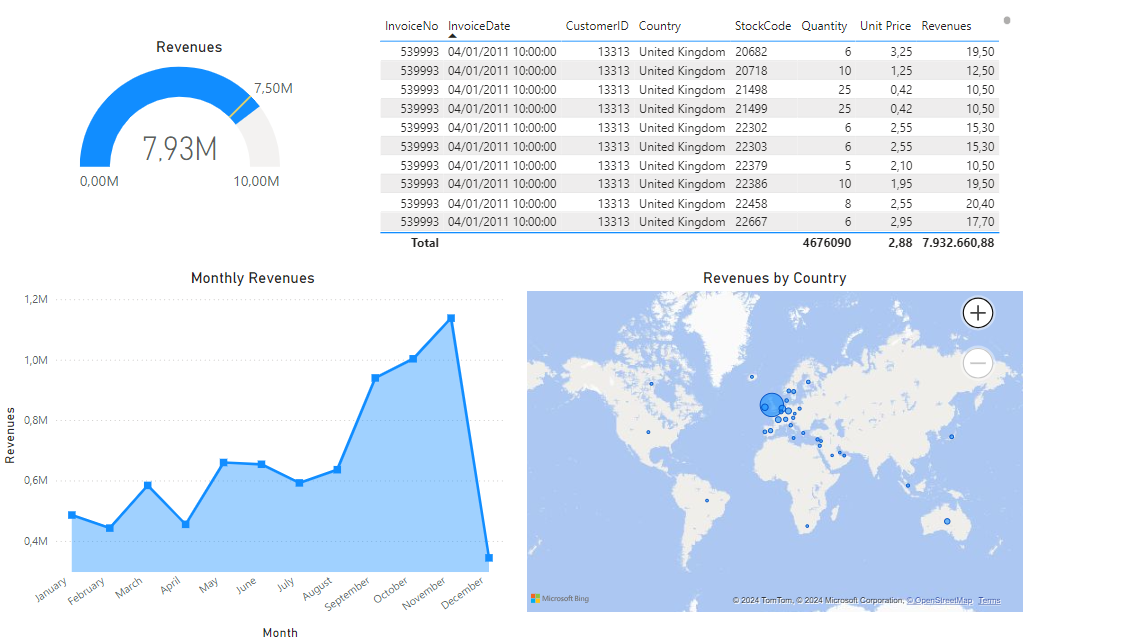

In [46]:
Image(filename='Sales_Data_Dashboard_PowerBI.png')
